<a href="https://colab.research.google.com/github/bramvandeurzen934/Group16_ECG/blob/main/assignment_ecg_SVC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment template -- ECG data

## Data loading and exploration

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [2]:
# Run this to use from colab environment
!git clone https://github.com/bramvandeurzen934/Group16_ECG.git

import zipfile
import os
import pandas as pd

with zipfile.ZipFile('/content/Group16_ECG/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Group16_ECG')

data = pd.read_csv('/content/Group16_ECG/ecg_data.csv', index_col=0)

labels = data['label']
feature_data = data.drop('label',axis = 1)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

fatal: destination path 'Group16_ECG' already exists and is not an empty directory.
The number of samples: 827
The number of columns: 9001


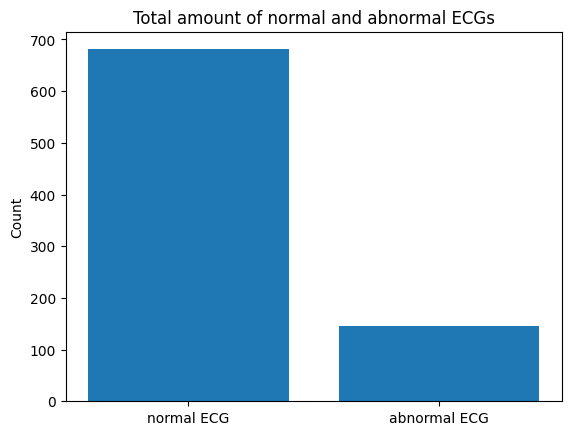

In [3]:
# Distribution labels
import matplotlib.pyplot as plt
text = ['normal ECG','abnormal ECG']
lst_labels = list(labels)
frequentie = [lst_labels.count(0), lst_labels.count(1)]
plt.bar(text, frequentie)
plt.title('Total amount of normal and abnormal ECGs')
plt.ylabel('Count')
plt.show()

This figure shows us that the data is unbalanced. The number of labels differs between the normal and abnormal ECGs. Based on the literature we will look for methods to compensate for the unbalanced data.

In [ ]:
# Testen per feature of het normaal verdeeld is per groep
from scipy.stats import shapiro

data_gezond = data[data["label"] == 0]
data_afwijkend = data[data["label"] == 1]

data_gezond = data_gezond.drop('label',axis = 1)
data_afwijkend = data_afwijkend.drop('label',axis = 1)

niet_nrml_vd_gezond = dict()
for kolomnaam in data_gezond.columns:
  statistiek = shapiro(list(data_gezond[kolomnaam]))
  if statistiek[1] > 0.05:
    niet_nrml_vd_gezond[kolomnaam] = statistiek[1]
print(niet_nrml_vd_gezond)

niet_nrml_vd_afwijkend = dict()
for kolomnaam in data_afwijkend.columns:
  statistiek = shapiro(list(data_afwijkend[kolomnaam]))
  if statistiek[1] > 0.05:
    niet_nrml_vd_afwijkend[kolomnaam] = statistiek[1]
print(niet_nrml_vd_afwijkend)



{}
{}


Based on the shapiro test with a p-value of 0.05 we found that all features are normally distributed. Therefore, we will use mean and standard deviation to describe the data.

### Missing values in data

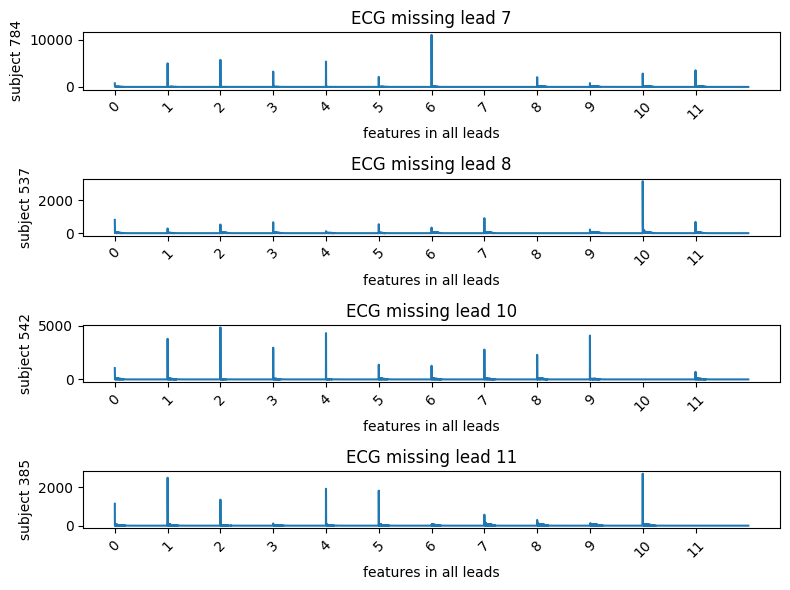

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(4, 1, figsize=(8, 6))

sns.lineplot(x = data.columns,y=data.iloc[784,:],ax = axes[0])
sns.lineplot(x = data.columns,y=data.iloc[537,:],ax = axes[1])
sns.lineplot(x = data.columns,y=data.iloc[542,:],ax = axes[2])
sns.lineplot(x = data.columns,y=data.iloc[385,:],ax = axes[3])


axes[0].set_xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
axes[1].set_xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
axes[2].set_xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
axes[3].set_xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)

axes[0].set(ylabel = 'subject 784',
            xlabel = 'features in all leads',
            title = 'ECG missing lead 7')
axes[1].set(ylabel = 'subject 537',
            xlabel = 'features in all leads',
            title = 'ECG missing lead 8')
axes[2].set(ylabel = 'subject 542',
            xlabel = 'features in all leads',
            title = 'ECG missing lead 10')
axes[3].set(ylabel = 'subject 385',
            xlabel = 'features in all leads',
            title = 'ECG missing lead 11')

plt.tight_layout()

plt.show()

### Sorting the features on greatest significant differences between abnormal and normal ECG
A two tailed T-test is performed on the data per feature. The test will find if there is a significant difference between the normal and abnormal ECG per feature. The features are sorted based on the p-value. The five most distinctive features are shown in the pairplot.

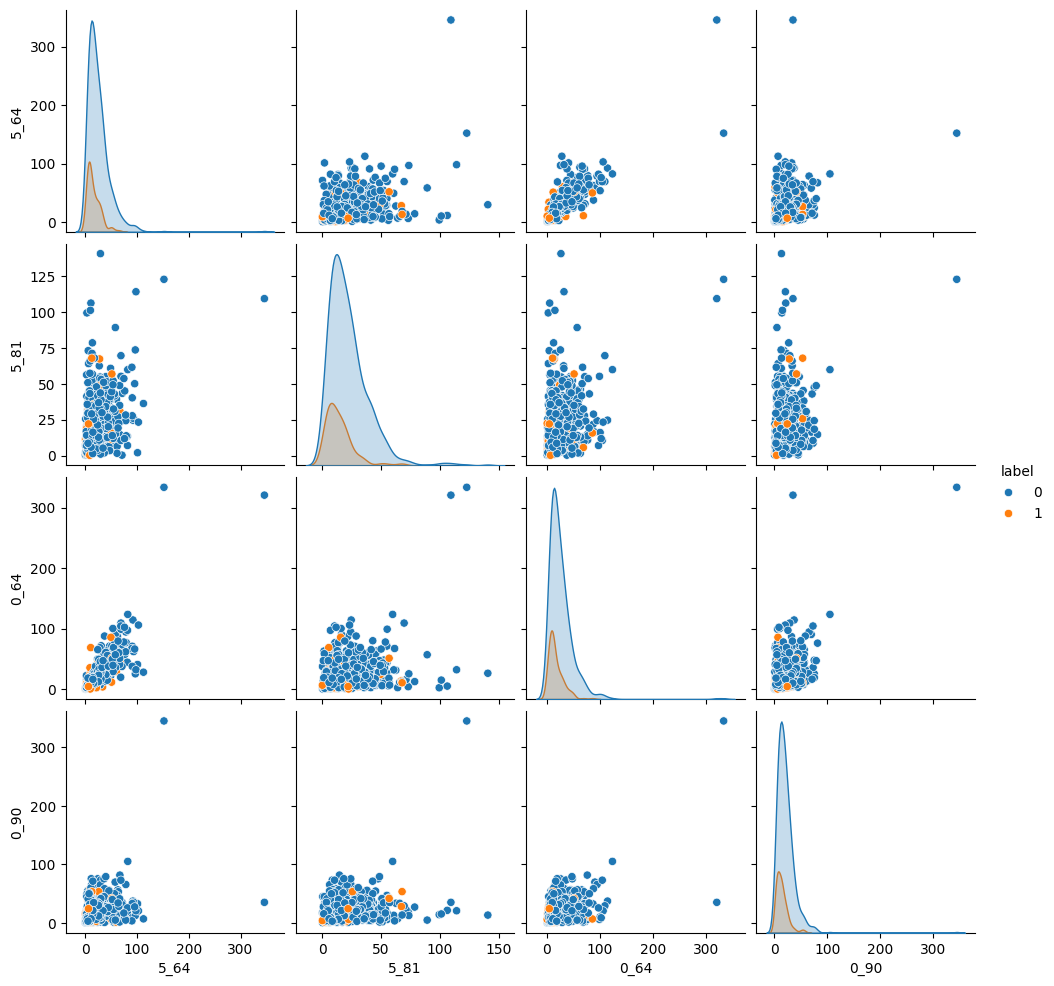

In [ ]:
from scipy.stats import ttest_ind
import numpy as np
import seaborn as sns

p_values = ttest_ind(a=data_gezond, b=data_afwijkend, axis = 0, equal_var=False)

dict_p_values = dict()
for kolom in data_gezond.columns:
  p_value = ttest_ind(data_gezond[kolom],data_afwijkend[kolom],equal_var=False)
  dict_p_values[kolom] = p_value[1]

dict_sorted_p_values = dict(sorted(dict_p_values.items(),key = lambda x:x[1]))
features_sorted = list(dict_sorted_p_values.keys())

most_sign_data = data[features_sorted[:4] + ["label"]]
sns.pairplot(data = most_sign_data,hue = "label")

In this figure we observe that the following two things:
*   The features are noramlly distributed for the normal and abnormal ECGs and outliers a present pulling the distribution to the right. (this corresponds to the shapiro tests we did before)
*  In the graphs where features are plotted against each other, we see that the samples are linearly distributed (a linear kernel to describe the data structure seems the most appropriate option)



## Data preprocessing

In this section we will perform imputation (missing values), normalisation (scaling) and oversampling to overcome unbalanced data.

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import seaborn as sns

X = data.copy()
X = X.drop('label',axis = 1)
y = data['label']

#Performing a stratified train-test split
sss =  StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

train_index, test_index = next(sss.split(X, y))

#Selecting the training and testing samples
X_train = X.iloc[train_index]
X_test  = X.iloc[test_index]
y_train = y.iloc[train_index]
y_test  = y.iloc[test_index]


## Printing of the results
print(f'splitted in stratified train-test split with {len(X_train)} training samples and {len(X_train)} testing samples')
print(f'Trainset (n={len(X_train)}): {round(sum(y_train == 1)/(sum(y_train == 0)+   sum(y_train == 1)),3)*100}% of samples is abnormal')
print(f'Testset (n={len(X_test)}): {round(sum(y_test == 1)/(sum(y_test == 0)+ sum(y_test == 1)),3)*100}% of samples is abnormal')

# preprocessing imputation
X_train.replace(0, np.nan, inplace=True) # dit wil je toch ook bij je test data doen - moet je dit niet voor de hele dataframe doen???

splitted in stratified train-test split with 661 training samples and 661 testing samples
Trainset (n=661): 17.7% of samples is abnormal
Testset (n=166): 17.5% of samples is abnormal


<ipython-input-21-8c40218a2b8b>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.replace(0, np.nan, inplace=True) # dit wil je toch ook bij je test data doen - moet je dit niet voor de hele dataframe doen???


### Choosing scaling method

In [ ]:
from sklearn import preprocessing

# standardscaler
scaler_st = preprocessing.StandardScaler()
scaler_st.fit(X_train)
X_train_st_scaled = pd.DataFrame(scaler_st.transform(X_train),columns = X_train.columns,index = X_train.index)
X_test_st_scaled = scaler_st.transform(X_test)

# smin max scaler
scaler_max = preprocessing.MinMaxScaler()
scaler_max.fit(X_train)
X_train_max_scaled = pd.DataFrame(scaler_max.transform(X_train),columns = X_train.columns,index = X_train.index)
X_test_max_scaled = scaler_max.transform(X_test)

# robust scaler
scaler_rob = preprocessing.RobustScaler()
scaler_rob.fit(X_train)
X_train_rob_scaled = pd.DataFrame(scaler_rob.transform(X_train),columns = X_train.columns,index = X_train.index)
X_test_rob_scaled = scaler_rob.transform(X_test)

# chose scaler is robust scaler
X_train_scaled = scaler_rob.transform(X_train)
X_test_scaled = scaler_rob.transform(X_test)

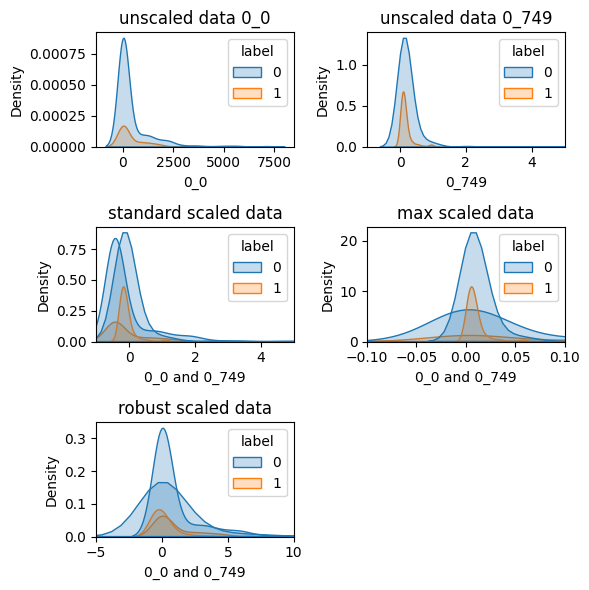

In [ ]:
# figures showing the scalers
fig, axs = plt.subplots(3,2,figsize = [6,6])

sns.kdeplot(data = X_train,x = '0_0',hue = y_train,fill = True, ax = axs[0,0])
axs[0,0].set(title = 'unscaled data 0_0')

sns.kdeplot(data = X_train,x = '0_749',hue = y_train,fill = True, ax = axs[0,1])
axs[0,1].set(title = 'unscaled data 0_749',
             xlim = [-1,5])

sns.kdeplot(data = X_train_st_scaled,x = '0_0',hue = y_train,fill = True, ax = axs[1,0])
sns.kdeplot(data = X_train_st_scaled,x = '0_749',hue = y_train,fill = True, ax = axs[1,0])
axs[1,0].set(title = 'standard scaled data',
             xlim = [-1,5],
             xlabel = '0_0 and 0_749')

sns.kdeplot(data = X_train_max_scaled,x = '0_0',hue = y_train,fill = True, ax = axs[1,1])
sns.kdeplot(data = X_train_max_scaled,x = '0_749',hue = y_train,fill = True, ax = axs[1,1])
axs[1,1].set(title = 'max scaled data',
             xlim = [-0.1,0.1],
             xlabel = '0_0 and 0_749')

sns.kdeplot(data = X_train_rob_scaled,x = '0_0',hue = y_train,fill = True, ax = axs[2,0])
sns.kdeplot(data = X_train_rob_scaled,x = '0_749',hue = y_train,fill = True, ax = axs[2,0])
axs[2,0].set(title = 'robust scaled data',
             xlim = [-5,10],
             xlabel = '0_0 and 0_749')

axs[2,1].remove()

plt.tight_layout()

Conclusions:
*   Minimum maximum scaler will not be used. When outliers are present such as in feature 0_0 we observe that distribution of feature 0_0 gets flattened. Inliers are cropped with the max scaler resulting in a deviated distribution from the original feature.
*   Robust scaler: scales the data with the IQR and median. It retains the distribution of the data especially when the distribution is not Gaussian. It is particularly useful when there is a non normal distribution.
*   Standard scaler: as there is a bit of skewness in the data of feature 0_0 we see when using the mean and standard deviation that the distribution shifts to the left. Because of outliers you can observe that the data inclines to the right (there data is not perfectly normal distributed). **When you are using standards scaled data, the mean is shifted towards the outliers and with robust scaling we don't have problems with this. **

Overall conclusions:
*   Robust scaler is preferred (other benefits: more stable and versatile)
*   Skewness is present (caused by outliers)
*   Normal distribution is perceivable (as tested by Eva before)

### Preprocessing
In this section we apply the computations we discussed in the literature/experiments.

750


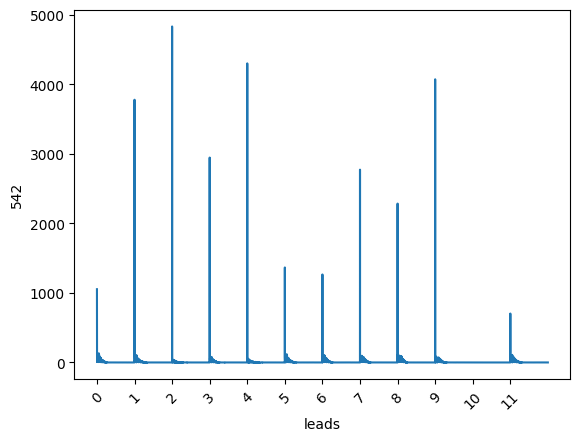

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
print((X_train.loc[542,:] == 0).sum())
fig = plt.figure()
sns.lineplot(x = X_train.columns,y=X_train.loc[542,:])
plt.xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
plt.xlabel('leads')
plt.show()

In [ ]:
from sklearn.impute import SimpleImputer
# 1) Replacing the zero values with their mean #
#X_train.replace(0, np.nan, inplace=True) # dit wil je toch ook bij je test data doen - moet je dit niet voor de hele dataframe doen???
imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')
imp_median.fit(X_train)
X_train_imputed = pd.DataFrame(imp_median.transform(X_train),columns = X_train.columns,index = X_train.index)

0


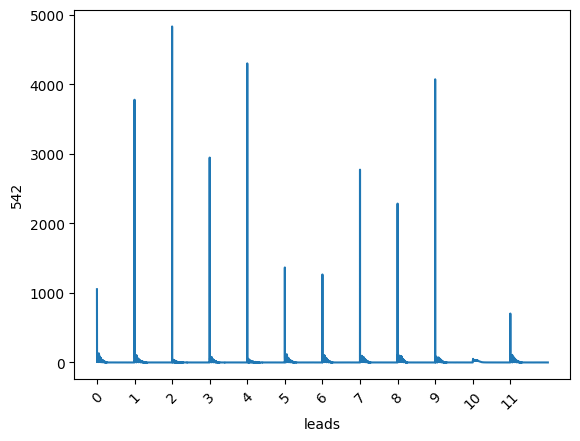

In [ ]:
print((X_train_imputed.loc[542,:] == 0).sum())
fig = plt.figure()
sns.lineplot(x = X_train_imputed.columns,y=X_train_imputed.loc[542,:])
plt.xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
plt.xlabel('leads')
plt.show()

In [6]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
import numpy as np
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import Lasso
from sklearn.feature_selection import mutual_info_classif, SelectKBest, RFECV
import seaborn as sns
import matplotlib.pyplot as plt


####### PREPROCESSING #######
# 1) Replacing the zero values with their mean #
# X_train.replace(0, np.nan, inplace=True)
# imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')
# imp_median.fit(X_train)
# X_train_imputed = pd.DataFrame(imp_median.transform(X_train),columns = X_train.columns,index = X_train.index)
# X_test_imputed = pd.DataFrame(imp_median.transform(X_test),columns = X_test.columns, index = X_test.index)

# # 2) Normalizing the data #
# # robust scaler
# scaler = preprocessing.RobustScaler()
# scaler.fit(X_train_imputed)
# X_train_scaled = pd.DataFrame(scaler.transform(X_train_imputed),columns = X_train_imputed.columns,index = X_train_imputed.index)
# X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed),columns = X_test_imputed.columns,index = X_test_imputed.index)

# 3) Oversampling
# oversampler = SMOTE()
# X_train_oversampled,y_train_oversampled = oversampler.fit_resample(X_train_scaled,y_train)

Due to oversampling the labels are equally distributed (n = 544 for each label)

## Feature selection and extraction
We will perform feature selection because we observed the curse of dimensionality (9000 features). Our first goal is to reduce the number of features. We first chose other/simpler feature reduction techniques than PCA because PCA is hard to interpret by clinicians.


In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel, mutual_info_classif
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import RobustScaler

# X_train = X_train_scaled
# X_test = X_test_scaled

# Display the weights and compute error for multiple values for alpha
n_alphas = 15
alphas = np.logspace(-4, -1, n_alphas)
scores_lasso = []
n_features_lasso = []
features_lasso = {}
feature_names_lasso = {}

for alpha in alphas:
  lasso = Lasso(alpha = alpha,random_state = 1)
  # Define the pipeline
  pipeline = Pipeline([
       ('imputation',SimpleImputer(missing_values=np.nan,strategy = 'median')),
       ('scaling',RobustScaler()),
       ('selectmodel',SelectFromModel(lasso)),
       ('sampling',RandomOverSampler(random_state=1)),
       ('model', SVC(random_state=1)),                  # Step 4: SMOTE for oversampling
  ])

  # Define parameter grid for GridSearchCV
  param_grid = {
      'model__kernel': ['linear']
  }
  # Create GridSearchCV object
  grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=2,verbose = 2,error_score='raise',scoring = 'f1')

  # Fit GridSearchCV to the training data
  grid_search.fit(X_train, y_train)

  # Print best parameters and best score
  print(f"Best parameters {alpha}:", grid_search.best_params_)
  print(f"Best score F1 {alpha}:", grid_search.best_score_)

  scores_lasso.append(grid_search.cv_results_['mean_test_score'])

    # Access the SelectFromModel transformer from the pipeline after fitting
  selectmodel = grid_search.best_estimator_.named_steps['selectmodel']
  selected_features_lasso = sum(selectmodel.get_support())
  n_features_lasso.append(selected_features_lasso)
  features_lasso[alpha] = X_train.loc[:,selectmodel.get_support()]


Fitting 2 folds for each of 1 candidates, totalling 2 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.776e-02, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   9.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.226e-01, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   4.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.062e-01, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Best parameters 0.0001: {'model__kernel': 'linear'}
Best score F1 0.0001: 0.42999353587588884
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.692e-01, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   4.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.541e-01, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   6.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.093e-01, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Best parameters 0.00016378937069540646: {'model__kernel': 'linear'}
Best score F1 0.00016378937069540646: 0.44379084967320265
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.637e-01, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   5.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.294e-01, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   5.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.750e-01, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Best parameters 0.00026826957952797245: {'model__kernel': 'linear'}
Best score F1 0.00026826957952797245: 0.4470659407138536
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.688e-01, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   4.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.986e-01, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   6.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.169e+00, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Best parameters 0.00043939705607607906: {'model__kernel': 'linear'}
Best score F1 0.00043939705607607906: 0.42826086956521736
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.439e-01, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   5.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.137e-01, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   4.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.551e+00, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Best parameters 0.0007196856730011522: {'model__kernel': 'linear'}
Best score F1 0.0007196856730011522: 0.44922630560928434
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.862e-01, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   4.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.067e-01, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   6.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.205e+00, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Best parameters 0.0011787686347935866: {'model__kernel': 'linear'}
Best score F1 0.0011787686347935866: 0.4580143540669856
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.474e-01, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   5.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.982e-01, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   4.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.223e+00, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Best parameters 0.0019306977288832496: {'model__kernel': 'linear'}
Best score F1 0.0019306977288832496: 0.4842738205365402
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.373e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   4.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.868e-01, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   4.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.580e+00, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Best parameters 0.0031622776601683794: {'model__kernel': 'linear'}
Best score F1 0.0031622776601683794: 0.4473118279569892
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.652e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   3.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.548e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   5.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.640e+00, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Best parameters 0.005179474679231213: {'model__kernel': 'linear'}
Best score F1 0.005179474679231213: 0.46203303403170376
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   5.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   4.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.357e+00, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Best parameters 0.008483428982440717: {'model__kernel': 'linear'}
Best score F1 0.008483428982440717: 0.5173374613003094
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.978e-02, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   4.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.208e-01, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   4.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.754e-01, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Best parameters 0.013894954943731374: {'model__kernel': 'linear'}
Best score F1 0.013894954943731374: 0.45751633986928103
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END ...............................model__kernel=linear; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.071e-02, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   4.3s
Best parameters 0.022758459260747887: {'model__kernel': 'linear'}
Best score F1 0.022758459260747887: 0.47900623395672903
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END ...............................model__kernel=linear; total time=   3.1s
[CV] END ...............................model__kernel=linear; total time=   2.8s
Best parameters 0.03727593720314938: {'model__kernel': 'linear'}
Best score F1 0.03727593720314938: 0.4681485497424776
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END ...............................model__kernel=linear; total time=   3.0s
[CV] END ...............................model__kernel=linear; total time=   3.3s
Best parameters 0.061054022965853265: {'model__kernel': 'linear'}
Best score F1 0.061054022965853265: 0.41017798734123445
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END ...............................model__kernel=l

In [ ]:
# Define the pipeline
pipeline = Pipeline([
    ('imputation',SimpleImputer(missing_values=np.nan,strategy = 'median')),
    ('scaling',RobustScaler()),
    ('reduce_dim', 'passthrough'),
    ('sampling',RandomOverSampler(random_state=1)),
    ('model', SVC()),
])

# Define parameter grid for GridSearchCV
param_grid = [{
    'reduce_dim': [SelectKBest()],
    'reduce_dim__k': [10,50,100,200,300,400,800,1500],
    'model__kernel': ['linear']
},
              {
    'reduce_dim': [KernelPCA(kernel = 'linear')],
    'reduce_dim__n_components': [10,50,100,200,300,400,800,1500],
    'model__kernel': ['linear']

              }]
# Create GridSearchCV object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=2,verbose = 2,scoring = 'f1')

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_
# Print best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


# # Extract selected features indices
# selected_features = best_model.named_steps['feature_selection'].get_support(indices=True)
# features_univariate = X_train.iloc[:,selected_features]
# # Print indices of selected features
# print("Selected features",X_train.iloc[:,selected_features].columns)


Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] END model__kernel=linear, reduce_dim=SelectKBest(), reduce_dim__k=10; total time=   3.9s
[CV] END model__kernel=linear, reduce_dim=SelectKBest(), reduce_dim__k=10; total time=   2.1s
[CV] END model__kernel=linear, reduce_dim=SelectKBest(), reduce_dim__k=50; total time=   2.8s
[CV] END model__kernel=linear, reduce_dim=SelectKBest(), reduce_dim__k=50; total time=   2.9s
[CV] END model__kernel=linear, reduce_dim=SelectKBest(), reduce_dim__k=100; total time=   2.3s
[CV] END model__kernel=linear, reduce_dim=SelectKBest(), reduce_dim__k=100; total time=   2.1s
[CV] END model__kernel=linear, reduce_dim=SelectKBest(), reduce_dim__k=200; total time=   2.1s
[CV] END model__kernel=linear, reduce_dim=SelectKBest(), reduce_dim__k=200; total time=   2.2s
[CV] END model__kernel=linear, reduce_dim=SelectKBest(), reduce_dim__k=300; total time=   3.1s
[CV] END model__kernel=linear, reduce_dim=SelectKBest(), reduce_dim__k=300; total time= 

In [ ]:
n_features_k = grid_search.cv_results_['param_reduce_dim__k'].compressed()
n_features_pca = grid_search.cv_results_['param_reduce_dim__n_components'].compressed()

In [ ]:
mean_test_scores = grid_search.cv_results_['mean_test_score']
mean_test_scores_k = mean_test_scores[:int((len(mean_test_scores)/2))]
mean_test_scores_pca = mean_test_scores[int((len(mean_test_scores)/2)):int(len(mean_test_scores))]

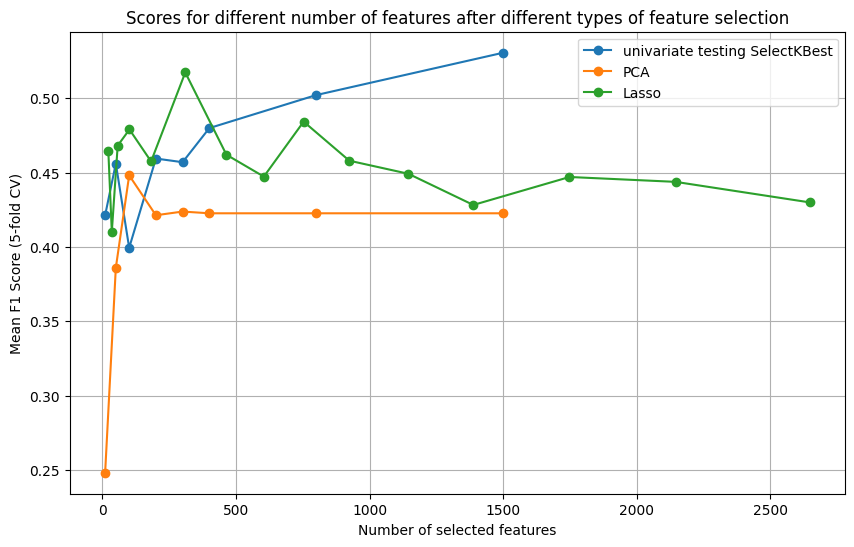

In [ ]:
# Extract mean test scores and parameter values from cv_results_
# Plot mean test scores against parameter values
plt.figure(figsize=(10, 6))
plt.plot(n_features_k, mean_test_scores_k, marker='o', linestyle='-')
plt.plot(n_features_pca, mean_test_scores_pca, marker='o', linestyle='-')
plt.plot(n_features_lasso,scores_lasso,marker='o')

plt.title('Scores for different number of features after different types of feature selection')
plt.xlabel('Number of selected features')
plt.ylabel('Mean F1 Score (5-fold CV)')
plt.legend(['univariate testing SelectKBest','PCA','Lasso'])
plt.grid()
plt.show()

In [ ]:
n_features_lasso

[2647, 2145, 1748, 1388, 1145, 924, 753, 604, 464, 310, 182, 101, 57, 35, 22]

In [ ]:
alphas

array([0.0001    , 0.00016379, 0.00026827, 0.0004394 , 0.00071969,
       0.00117877, 0.0019307 , 0.00316228, 0.00517947, 0.00848343,
       0.01389495, 0.02275846, 0.03727594, 0.06105402, 0.1       ])

In [ ]:
opt_n_features_lasso = n_features_lasso[scores_lasso.index(max(scores_lasso))]
opt_alpha_lasso = alphas[scores_lasso.index(max(scores_lasso))]
opt_alpha_lasso

0.008483428982440717

Conclusion based on grid search for two different feature selection techniques:
*  Lasso feature selection: the graph shows us that the top of the graph is reached between 500 and 1000 features. This amount of features have to be selected to get the optimal F1 score. This leads to the curse of dimensionality and overfitting.
*   Univariate testing: Each added feature contributes to an increment of the F1 score. Preferably, we would choose 800 features or more but this will lead to the curse of dimensionality.

As we found that 500-1000 features are preferable we are still faced with the curse of dimensionality because the number of features (500) is large comopared to the number of samples (827). Therefore we have the risk of overfitting (as we also saw in the learning curve). There are several methods of preventing overfitting. One of them is PCA: preferably you would like to capture the information of all these features in a few new features which possess the characteristics of the data (like PCA)

Other methods to mitigate the risk of overfitting when dealing with high-dimensional data, you can consider:

*   Feature Selection: Use techniques like feature selection to identify the most informative features and reduce the dimensionality of the feature space. (already done)
*   Cross-Validation: Use cross-validation to assess the generalization performance of the model and tune hyperparameters to prevent overfitting. (already done)
*   Dimensionality Reduction: Use dimensionality reduction techniques like Principal Component Analysis (PCA) or t-distributed Stochastic Neighbor Embedding (t-SNE) to project the data onto a lower-dimensional space while preserving as much variance as possible. (to be done)
*   Regularization: Apply regularization techniques like L1 (Lasso) or L2 (Ridge) regularization to penalize large coefficients and prevent overfitting. (to be done if PCA is insufficient)








## PCA
In this section we will perform PCA and experiment which settings are optimal for PCA execution.

## Classifiers

In [7]:
import time
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel, mutual_info_classif
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import RobustScaler

# Classifiers
classifiers = {
    "KNN" : KNeighborsClassifier(),
    "SVC" : SVC(random_state=0, probability=True),
    "RandomForest" : RandomForestClassifier(random_state=0)}

# Grids for grid search
KNN_grid = {'estimator__n_neighbors': [3, 5, 7, 9, 15],
            'estimator__p': [1, 2]}

SVC_grid = {'estimator__C': [0.05,0.1,0.25, 0.5],
            'estimator__kernel': ['linear'],
            'estimator__gamma': ['scale'],
            'estimator__degree': [2],  # degrees for polynomial kernel
            'estimator__coef0': [0.0, 0.1]  # homogeneity parameter
            }

RF_grid = {'estimator__n_estimators': [50,100, 200, 300,500],
        'estimator__max_depth': [4, 8, 10, 12]}

# Dictionary of all grids
grid = {
   "KNN" : KNN_grid,
    "SVC" : SVC_grid,
    "RandomForest" : RF_grid}


i=0
clf_best_params={}
clf_best_model={}

valid_scores=pd.DataFrame({'Classifer':classifiers.keys(), 'Validation F1 score': np.zeros(len(classifiers)), 'Training time': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    start = time.time()

    # 0.008483428982440717 = n_opt_alpha
    lasso = Lasso(alpha =  0.008483428982440717,random_state=1)

    pipeline = Pipeline([
      ('imputation',SimpleImputer(missing_values=np.nan,strategy = 'median')),
      ('scaling',RobustScaler()),
      ('feature_selection',SelectFromModel(lasso)),
      ('sampling',RandomOverSampler(random_state=1)),
      ('estimator', classifier),
      ])

    clf = GridSearchCV(estimator=pipeline, param_grid=grid[key], cv=2,scoring = 'f1',verbose = 3)

    # Train and score
    clf.fit(X_train, y_train)
    valid_scores.iloc[i,1]=clf.best_score_

    # Save trained model
    clf_best_params[key]=clf.best_params_
    clf_best_model[key] = clf.best_estimator_

    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,2]=np.round((stop - start)/60, 2)

    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,2])
    print('')
    i+=1


Fitting 2 folds for each of 10 candidates, totalling 20 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__n_neighbors=3, estimator__p=1;, score=0.381 total time=   6.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__n_neighbors=3, estimator__p=1;, score=0.280 total time=   4.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__n_neighbors=3, estimator__p=2;, score=0.470 total time=   5.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__n_neighbors=3, estimator__p=2;, score=0.362 total time=   6.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__n_neighbors=5, estimator__p=1;, score=0.367 total time=   5.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__n_neighbors=5, estimator__p=1;, score=0.273 total time=   6.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__n_neighbors=5, estimator__p=2;, score=0.441 total time=   5.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__n_neighbors=5, estimator__p=2;, score=0.393 total time=  10.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__n_neighbors=7, estimator__p=1;, score=0.404 total time=   7.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__n_neighbors=7, estimator__p=1;, score=0.288 total time=   9.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__n_neighbors=7, estimator__p=2;, score=0.462 total time=   4.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__n_neighbors=7, estimator__p=2;, score=0.354 total time=   5.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__n_neighbors=9, estimator__p=1;, score=0.397 total time=   5.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__n_neighbors=9, estimator__p=1;, score=0.336 total time=   6.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__n_neighbors=9, estimator__p=2;, score=0.415 total time=   5.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__n_neighbors=9, estimator__p=2;, score=0.313 total time=   4.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__n_neighbors=15, estimator__p=1;, score=0.463 total time=   6.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__n_neighbors=15, estimator__p=1;, score=0.350 total time=   5.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__n_neighbors=15, estimator__p=2;, score=0.404 total time=   6.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__n_neighbors=15, estimator__p=2;, score=0.340 total time=   5.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.357e+00, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Model: KNN
Training time (mins): 2.24

Fitting 2 folds for each of 8 candidates, totalling 16 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__C=0.05, estimator__coef0=0.0, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.505 total time=   4.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__C=0.05, estimator__coef0=0.0, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.529 total time=   6.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__C=0.05, estimator__coef0=0.1, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.505 total time=   5.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__C=0.05, estimator__coef0=0.1, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.529 total time=   5.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__C=0.1, estimator__coef0=0.0, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.505 total time=   6.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__C=0.1, estimator__coef0=0.0, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.529 total time=   4.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__C=0.1, estimator__coef0=0.1, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.505 total time=   6.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__C=0.1, estimator__coef0=0.1, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.529 total time=   5.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__C=0.25, estimator__coef0=0.0, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.505 total time=   5.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__C=0.25, estimator__coef0=0.0, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.529 total time=   6.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__C=0.25, estimator__coef0=0.1, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.505 total time=   5.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__C=0.25, estimator__coef0=0.1, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.529 total time=   7.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__C=0.5, estimator__coef0=0.0, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.505 total time=   5.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__C=0.5, estimator__coef0=0.0, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.529 total time=   6.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__C=0.5, estimator__coef0=0.1, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.505 total time=   5.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__C=0.5, estimator__coef0=0.1, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.529 total time=   5.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.357e+00, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Model: SVC
Training time (mins): 1.71

Fitting 2 folds for each of 20 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__max_depth=4, estimator__n_estimators=50;, score=0.429 total time=   6.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__max_depth=4, estimator__n_estimators=50;, score=0.364 total time=   5.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__max_depth=4, estimator__n_estimators=100;, score=0.458 total time=  17.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__max_depth=4, estimator__n_estimators=100;, score=0.400 total time=  15.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__max_depth=4, estimator__n_estimators=200;, score=0.452 total time=  13.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__max_depth=4, estimator__n_estimators=200;, score=0.386 total time=  15.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__max_depth=4, estimator__n_estimators=300;, score=0.458 total time=   6.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__max_depth=4, estimator__n_estimators=300;, score=0.395 total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__max_depth=4, estimator__n_estimators=500;, score=0.471 total time=   7.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__max_depth=4, estimator__n_estimators=500;, score=0.381 total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__max_depth=8, estimator__n_estimators=50;, score=0.254 total time=   6.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__max_depth=8, estimator__n_estimators=50;, score=0.209 total time=   6.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__max_depth=8, estimator__n_estimators=100;, score=0.232 total time=   5.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__max_depth=8, estimator__n_estimators=100;, score=0.290 total time=   7.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__max_depth=8, estimator__n_estimators=200;, score=0.261 total time=   5.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__max_depth=8, estimator__n_estimators=200;, score=0.286 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__max_depth=8, estimator__n_estimators=300;, score=0.232 total time=   7.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__max_depth=8, estimator__n_estimators=300;, score=0.290 total time=   9.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__max_depth=8, estimator__n_estimators=500;, score=0.232 total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__max_depth=8, estimator__n_estimators=500;, score=0.310 total time=   7.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__max_depth=10, estimator__n_estimators=50;, score=0.232 total time=   6.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__max_depth=10, estimator__n_estimators=50;, score=0.209 total time=   5.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__max_depth=10, estimator__n_estimators=100;, score=0.206 total time=   5.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__max_depth=10, estimator__n_estimators=100;, score=0.290 total time=   6.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__max_depth=10, estimator__n_estimators=200;, score=0.182 total time=   6.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__max_depth=10, estimator__n_estimators=200;, score=0.290 total time=   7.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__max_depth=10, estimator__n_estimators=300;, score=0.179 total time=   7.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__max_depth=10, estimator__n_estimators=300;, score=0.265 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__max_depth=10, estimator__n_estimators=500;, score=0.182 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__max_depth=10, estimator__n_estimators=500;, score=0.265 total time=   6.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__max_depth=12, estimator__n_estimators=50;, score=0.206 total time=   7.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__max_depth=12, estimator__n_estimators=50;, score=0.179 total time=   5.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__max_depth=12, estimator__n_estimators=100;, score=0.206 total time=   5.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__max_depth=12, estimator__n_estimators=100;, score=0.261 total time=   6.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__max_depth=12, estimator__n_estimators=200;, score=0.209 total time=   5.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__max_depth=12, estimator__n_estimators=200;, score=0.261 total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__max_depth=12, estimator__n_estimators=300;, score=0.179 total time=   6.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__max_depth=12, estimator__n_estimators=300;, score=0.239 total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+00, tolerance: 4.781e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/2] END estimator__max_depth=12, estimator__n_estimators=500;, score=0.182 total time=   9.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.090e+00, tolerance: 4.848e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/2] END estimator__max_depth=12, estimator__n_estimators=500;, score=0.239 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.357e+00, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Model: RandomForest
Training time (mins): 5.47



In [8]:
valid_scores

,Classifer,Validation F1 score,Training time
0,KNN,0.416734,2.24
1,SVC,0.517337,1.71
2,RandomForest,0.428916,5.47


In [9]:
clf_best_params

{'KNN': {'estimator__n_neighbors': 5, 'estimator__p': 2},
 'SVC': {'estimator__C': 0.05,
  'estimator__coef0': 0.0,
  'estimator__degree': 2,
  'estimator__gamma': 'scale',
  'estimator__kernel': 'linear'},
 'RandomForest': {'estimator__max_depth': 4, 'estimator__n_estimators': 100}}

In [ ]:
clf_best_model

{'KNN': Pipeline(steps=[('imputation', SimpleImputer(strategy='median')),
                 ('scaling', RobustScaler()),
                 ('feature_selection',
                  SelectFromModel(estimator=Lasso(alpha=0.008483428982440717))),
                 ('sampling', RandomOverSampler(random_state=1)),
                 ('estimator', KNeighborsClassifier())]),
 'SVC': Pipeline(steps=[('imputation', SimpleImputer(strategy='median')),
                 ('scaling', RobustScaler()),
                 ('feature_selection',
                  SelectFromModel(estimator=Lasso(alpha=0.008483428982440717))),
                 ('sampling', RandomOverSampler(random_state=1)),
                 ('estimator',
                  SVC(C=0.25, degree=2, kernel='linear', probability=True,
                      random_state=0))]),
 'RandomForest': Pipeline(steps=[('imputation', SimpleImputer(strategy='median')),
                 ('scaling', RobustScaler()),
                 ('feature_selection',
              

22


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.194e-01, tolerance: 9.231e-04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.393e-01, tolerance: 1.619e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.504e-01, tolerance: 2.492e

22


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.194e-01, tolerance: 9.231e-04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.393e-01, tolerance: 1.619e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.504e-01, tolerance: 2.492e

22


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.194e-01, tolerance: 9.231e-04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.393e-01, tolerance: 1.619e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.504e-01, tolerance: 2.492e

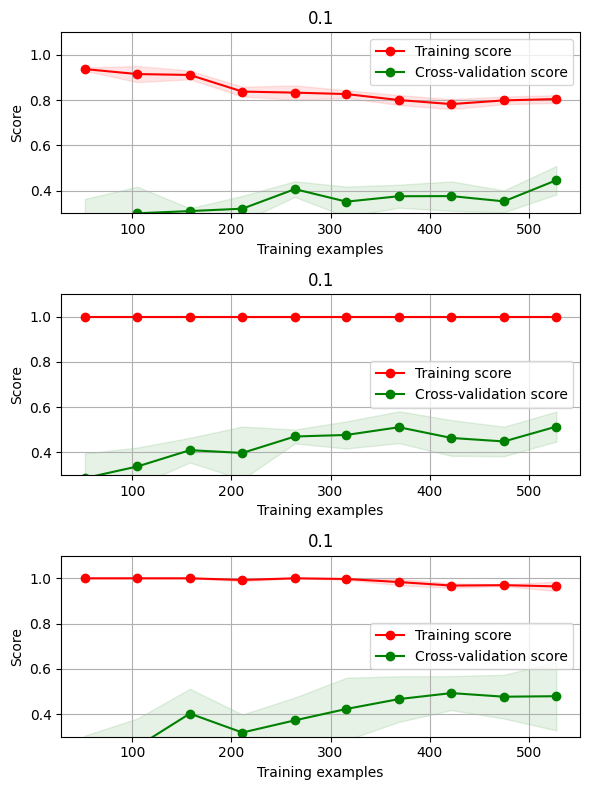

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("F1 Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,scoring = 'f1')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

  # Now use the classifiers on all datasets
num = 0
fig = plt.figure(figsize=(6,8))
for key, clf in clf_best_model.items():
      # Split data in training and testing
      feature_lasso = features_lasso[alpha]
      title = f'F1 score: {key}'
      ax = fig.add_subplot(3, 1, num + 1)
      plot_learning_curve(clf, title, X_train, y_train, ax, ylim=(0.2, 1.1), cv=5)
      num += 1
plt.tight_layout()
fig.show()


## Applying on test set

In [25]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score

accuracy = []
f_score = []
skf = StratifiedKFold(n_splits=5,shuffle = True, random_state=0)

for i, (train_index,test_index) in enumerate(skf.split(X,y)):
  X_train    = X.iloc[train_index]
  X_test     = X.iloc[test_index]
  y_train    = y.iloc[train_index]
  y_test     = y.iloc[test_index]
  ####### PREPROCESSING #######
  # Apply the different steps on the testset

  # preprocessing imputation
  X_test.replace(0, np.nan, inplace=True)

  # 1) Replacing the zero values with their mean #
  imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')
  imp_median.fit(X_train)
  X_train = pd.DataFrame(imp_median.transform(X_train),columns = X_train.columns,index = X_train.index)
  X_test = pd.DataFrame(imp_median.transform(X_test),columns = X_test.columns, index = X_test.index)

  # 2) Normalizing the data #
  # robust scaler
  scaler = preprocessing.RobustScaler()
  scaler.fit(X_train)
  X_train = pd.DataFrame(scaler.transform(X_train),columns = X_train.columns,index = X_train.index)
  X_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns,index = X_test.index)

  # 3) Feature selection Lasso
  # Now first use the selectfrom model module. Select all features with a weight above the median.
  lasso = Lasso(alpha=0.008483428982440717)
  selector = SelectFromModel(lasso)
  n_original = X_train.shape[1]

  selector.fit(X_train, y_train)
  X_train = pd.DataFrame(selector.transform(X_train),columns = X_train.columns[selector.get_support()],index = X_train.index)
  X_test = pd.DataFrame(selector.transform(X_test),columns = X_train.columns,index = X_test.index)

  n_selected = X_test.shape[1]
  print(f"Selected {n_selected} from {n_original} features.")

  # Initialize RandomOverSampler
  sampler = RandomOverSampler(random_state=0)

  # Resample the training data
  X_train, y_train = sampler.fit_resample(X_train, y_train)

  # fitting best classifier
  pipeline_svc = clf_best_model['SVC']
  model_svc = pipeline_svc.named_steps['estimator']
  model_svc.fit(X_train,y_train)

  # prediction
  y_pred = model_svc.predict(X_test)
  # accuracy
  accuracy.append(accuracy_score(y_test,y_pred))
  f_score.append(f1_score(y_test,y_pred))
  print(f'F1-score: {f1_score(y_test,y_pred):.3f}')
  print(f'accuracy score: {accuracy_score(y_test,y_pred):.3f}')


print(f'A {i+1}-fold cross-validation was used to split the design into training and validation dataset.')
print(f'splitted in stratified train-test split with {len(X_train)} training samples and {len(X_train)} testing samples')
print(f'Trainingset (n={len(X_train)}): {round(sum(y_train == 1)/(sum(y_train == 0)+   sum(y_train == 1)),3)*100}% of samples is abnormal')
print(f'Validation set (n={len(X_test)}): {round(sum(y_test == 1)/(sum(y_test == 0)+ sum(y_test == 1)),3)*100}% of samples is abnormal')

<ipython-input-25-5f4295ca5cf0>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.replace(0, np.nan, inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.592e+00, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Selected 300 from 9000 features.
F1-score: 0.702
accuracy score: 0.898


<ipython-input-25-5f4295ca5cf0>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.replace(0, np.nan, inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.016e-01, tolerance: 9.564e-03
  model = cd_fast.enet_coordinate_descent(


Selected 298 from 9000 features.
F1-score: 0.491
accuracy score: 0.825


<ipython-input-25-5f4295ca5cf0>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.replace(0, np.nan, inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.485e+00, tolerance: 9.632e-03
  model = cd_fast.enet_coordinate_descent(


Selected 295 from 9000 features.
F1-score: 0.400
accuracy score: 0.836


<ipython-input-25-5f4295ca5cf0>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.replace(0, np.nan, inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.055e+00, tolerance: 9.632e-03
  model = cd_fast.enet_coordinate_descent(


Selected 328 from 9000 features.
F1-score: 0.561
accuracy score: 0.848


<ipython-input-25-5f4295ca5cf0>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.replace(0, np.nan, inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.185e+00, tolerance: 9.632e-03
  model = cd_fast.enet_coordinate_descent(


Selected 287 from 9000 features.
F1-score: 0.471
accuracy score: 0.836
A 5-fold cross-validation was used to split the design into training and validation dataset.
splitted in stratified train-test split with 1090 training samples and 1090 testing samples
Trainingset (n=1090): 50.0% of samples is abnormal
Validation set (n=165): 17.599999999999998% of samples is abnormal


In [10]:
accuracy

<ipython-input-10-4d1bdb4248cb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.replace(0, np.nan, inplace=True)


In [14]:
f1_score

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.357e+00, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Selected 310 from 9000 features.


SVC(C=0.05, degree=2, kernel='linear', probability=True, random_state=0)

Accuracy: 0.837
F1-score: 0.471


Confusion Matrix:
[[127  10]
 [ 17  12]]


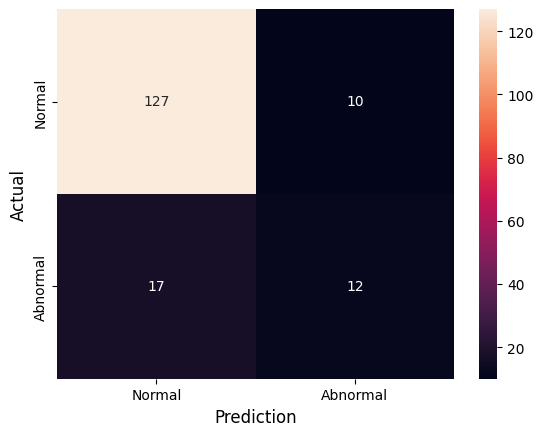

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# define and print matrix with labels
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Normal','Abnormal'],
            yticklabels=['Normal','Abnormal'])

# display matrix
plt.ylabel('Actual',fontsize=12)
plt.xlabel('Prediction',fontsize=12)
plt.show()

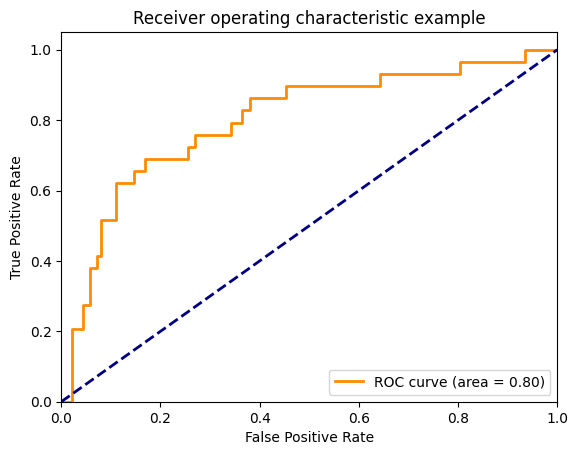

In [ ]:
# Create ROC curve
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_score, y_truth):
    '''
    Plot an ROC curve.
    '''
    # Only take scores for class = 1
    y_score = y_score[:, 1]

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_truth, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

y_proba = model_svc.predict_proba(X_test)
plot_roc_curve(y_proba, y_test)